<a href="https://colab.research.google.com/github/eberthrosales/Redes/blob/main/Proceso_ETL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

👉 Sube tu kaggle.json descargado desde tu cuenta de Kaggle


Saving kaggle.json to kaggle.json
Skipping, found downloaded files in "./iot-dataset-for-intrusion-detection-systems-ids" (use force=True to force download)
Archivos en carpeta descargada:
BoTNeTIoT-L01-v2.csv
BotNeTIoT-L01_label_NoDuplicates.csv
>>> Datos originales:
Shape: (2426574, 25)
   Unnamed: 0  MI_dir_L0.1_weight  MI_dir_L0.1_mean  MI_dir_L0.1_variance  \
0           0            1.000000         98.000000          0.000000e+00   
1           1            1.931640         98.000000          1.818989e-12   
2           2            2.904273         86.981750          2.311822e+02   
3           3            3.902546         83.655268          2.040614e+02   
4           4            4.902545         81.685828          1.775746e+02   

   H_L0.1_weight  H_L0.1_mean  H_L0.1_variance  HH_L0.1_weight  HH_L0.1_mean  \
0       1.000000    98.000000     0.000000e+00         1.00000          98.0   
1       1.931640    98.000000     1.818989e-12         1.93164          98.0   
2      

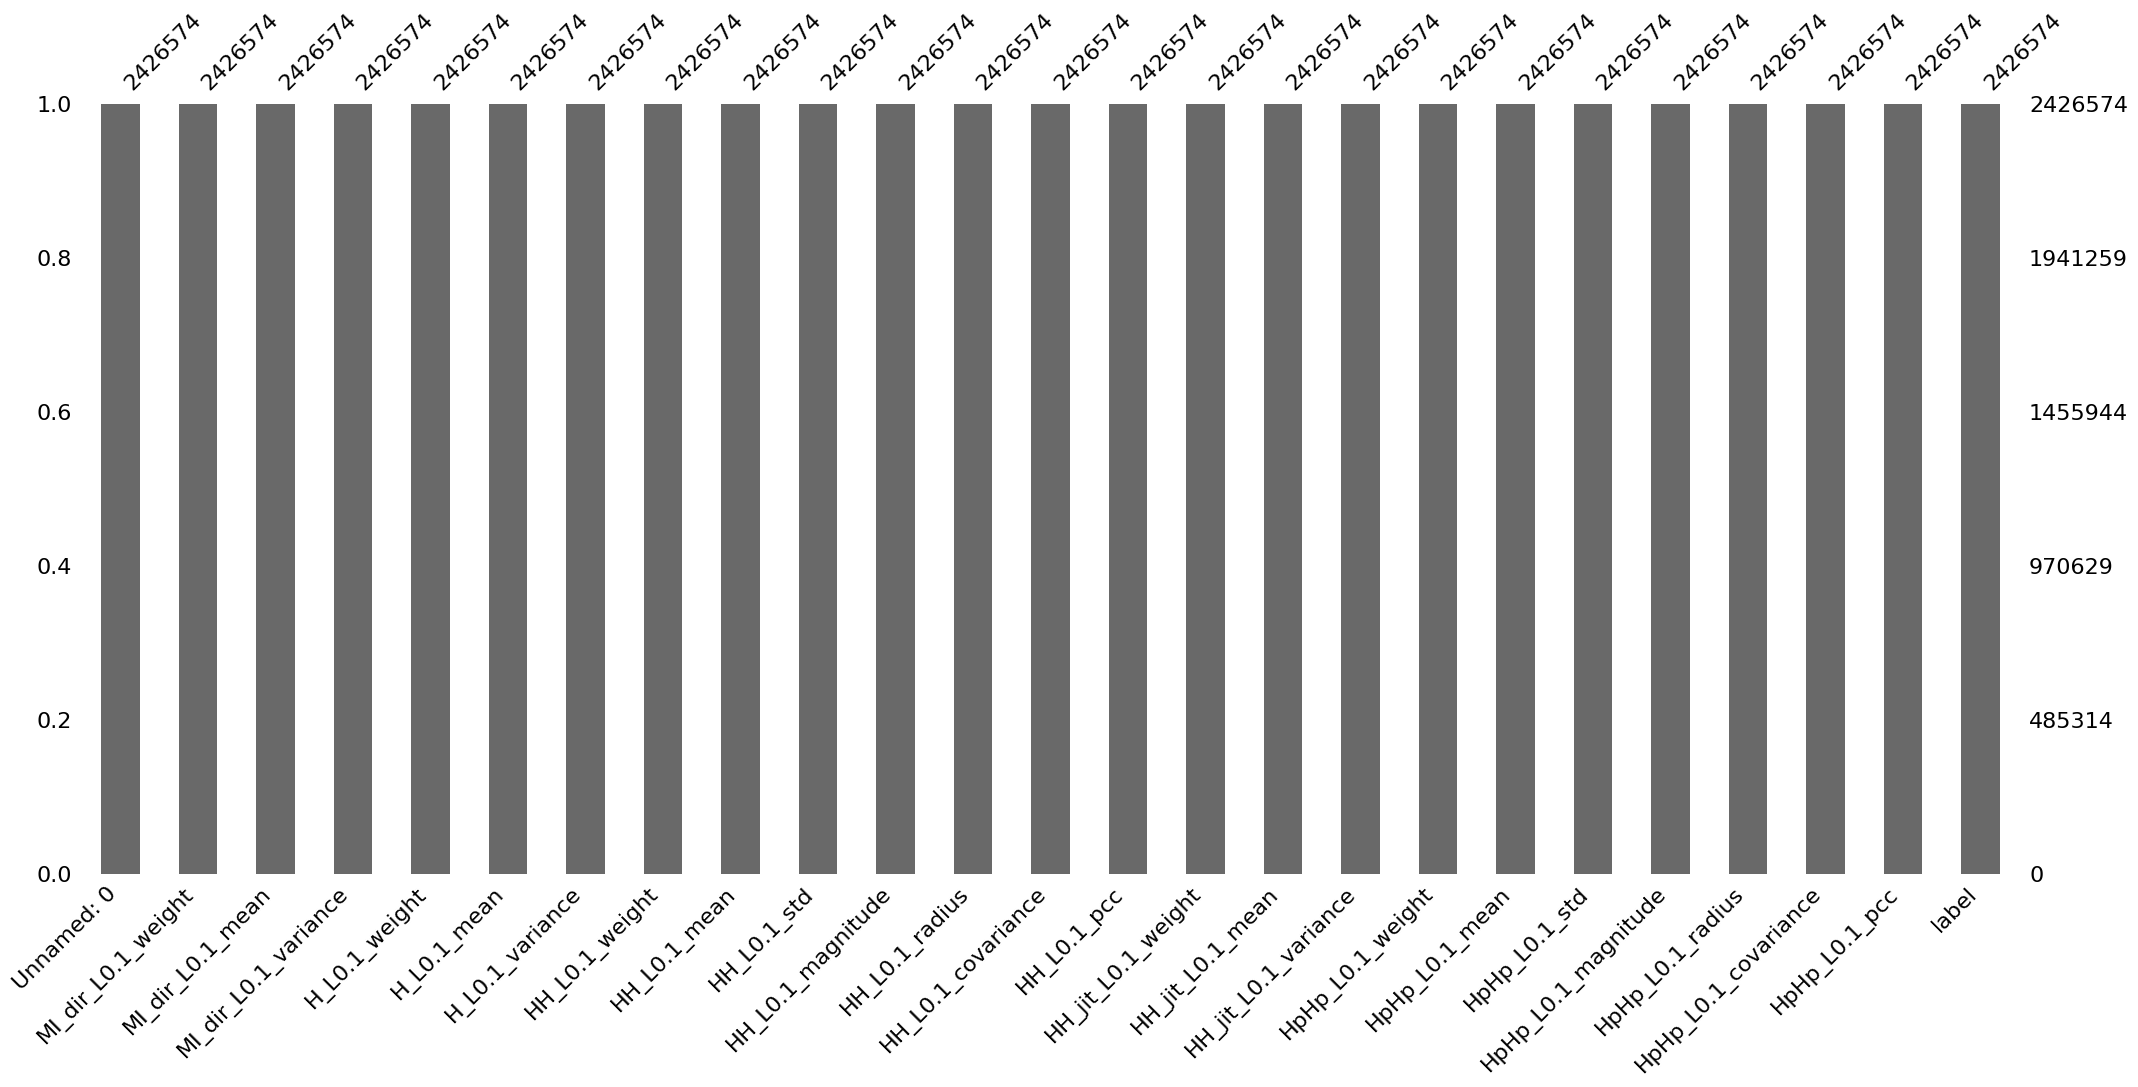

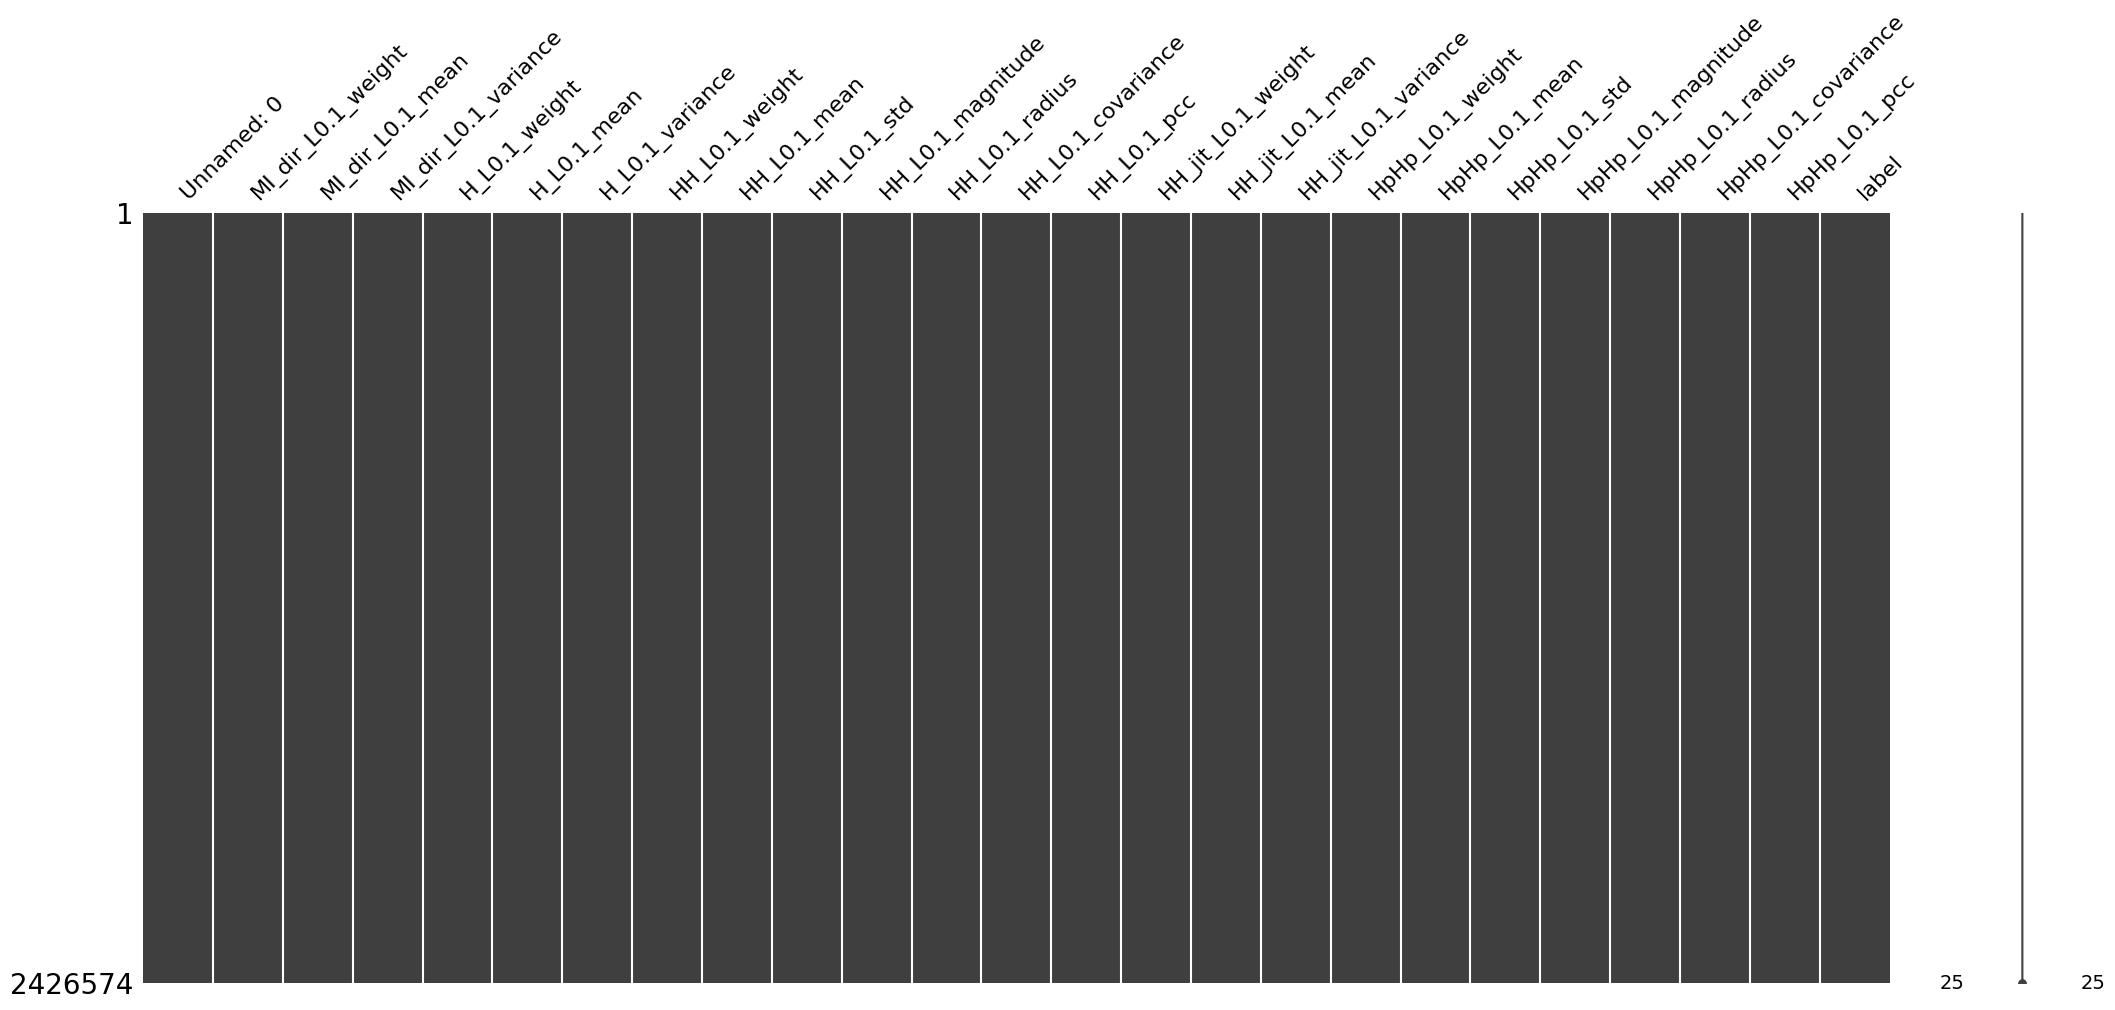

/tmp/ipython-input-133654178.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, palette="pastel")


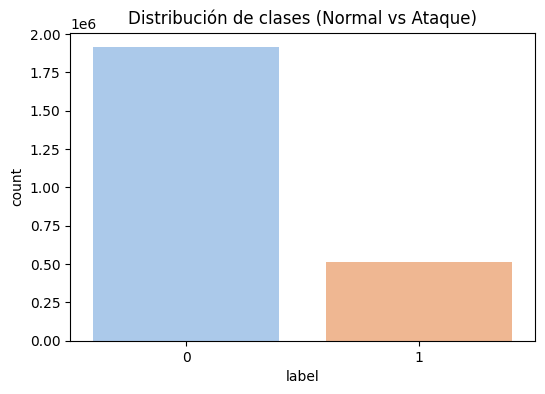

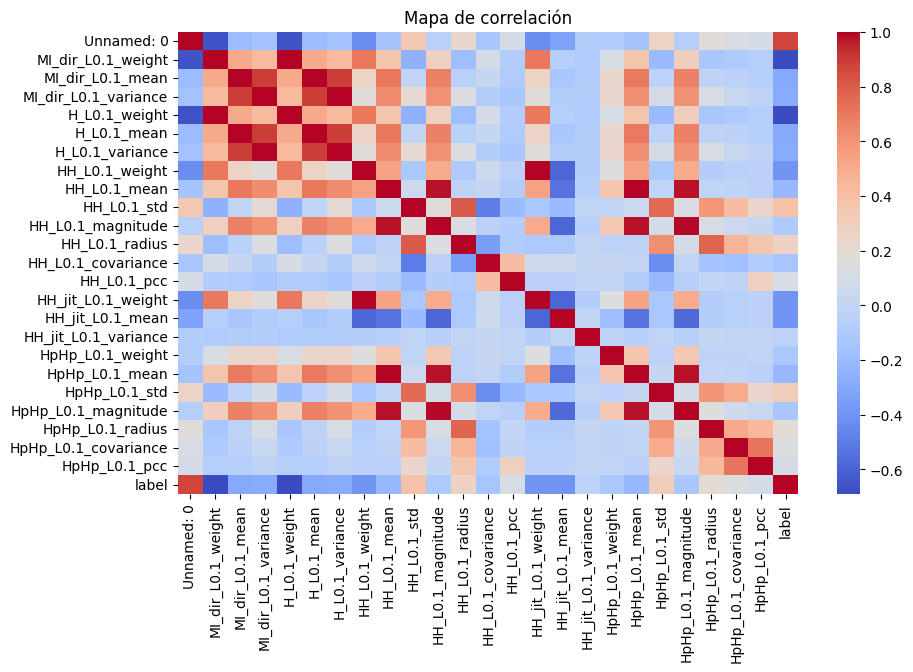


>>> Datos transformados:
Shape: (2426574, 26)
   unnamed:_0  mi_dir_l0.1_weight  mi_dir_l0.1_mean  mi_dir_l0.1_variance  \
0           0            1.000000         98.000000          0.000000e+00   
1           1            1.931640         98.000000          1.818989e-12   
2           2            2.904273         86.981750          2.311822e+02   
3           3            3.902546         83.655268          2.040614e+02   
4           4            4.902545         81.685828          1.775746e+02   

   h_l0.1_weight  h_l0.1_mean  h_l0.1_variance  hh_l0.1_weight  hh_l0.1_mean  \
0       1.000000    98.000000     0.000000e+00         1.00000          98.0   
1       1.931640    98.000000     1.818989e-12         1.93164          98.0   
2       2.904273    86.981750     2.311822e+02         1.00000          66.0   
3       3.902546    83.655268     2.040614e+02         1.00000          74.0   
4       4.902545    81.685828     1.775746e+02         2.00000          74.0   

    hh_l0

/tmp/ipython-input-133654178.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label_binaria", data=df, palette="Set2")


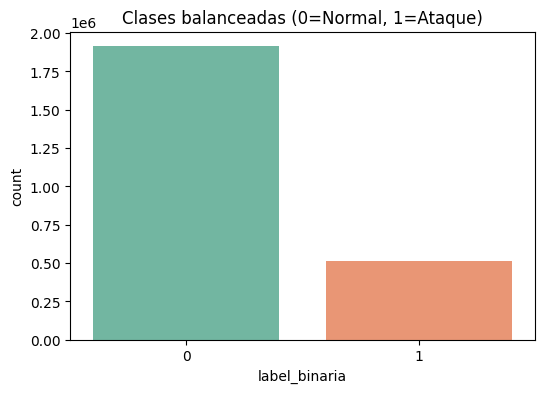


✅ ETL completado para versión NoDuplicates
Archivo CSV generado: botnet_clean_nodups.csv
Base SQLite: botnet_nodups.db


In [ ]:
# ========================
# ETL - IoT Intrusion Detection (BoT-IoT, versión NoDuplicates)
# ========================

# === 0. Subir credenciales de Kaggle ===
from google.colab import files
import os

print("👉 Sube tu kaggle.json descargado desde tu cuenta de Kaggle")
files.upload()  # sube kaggle.json manualmente

os.makedirs('/root/.kaggle', exist_ok=True)
if os.path.exists('kaggle.json'):
    os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
else:
    raise FileNotFoundError("kaggle.json no se encontró: asegúrate de haberlo subido.")
os.chmod('/root/.kaggle/kaggle.json', 0o600)

# === 1. Instalar librerías necesarias ===
!pip install --quiet opendatasets missingno seaborn plotly

# === 2. Descargar dataset desde Kaggle ===
import opendatasets as od
dataset_url = "https://www.kaggle.com/datasets/azalhowaide/iot-dataset-for-intrusion-detection-systems-ids"
od.download(dataset_url)

# === 3. Importar librerías ===
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px

# === 4. Extract: listar archivos y cargar dataset NoDuplicates ===
print("Archivos en carpeta descargada:")
for f in os.listdir("iot-dataset-for-intrusion-detection-systems-ids"):
    print(f)

file_path = "iot-dataset-for-intrusion-detection-systems-ids/BotNeTIoT-L01_label_NoDuplicates.csv"
df = pd.read_csv(file_path)

print(">>> Datos originales:")
print("Shape:", df.shape)
print(df.head())

# === 5. Análisis Exploratorio (EDA) ===
print("\n=== Información del dataset ===")
print(df.info())
print("\n=== Estadísticas descriptivas ===")
print(df.describe(include="all").T)

# Gráfico de valores nulos
print("\n>>> Distribución de valores nulos")
msno.bar(df)
plt.show()
msno.matrix(df)
plt.show()

# Distribución de etiquetas
if "label" in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x="label", data=df, palette="pastel")
    plt.title("Distribución de clases (Normal vs Ataque)")
    plt.show()

# Correlación de variables numéricas
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Mapa de correlación")
plt.show()

# Distribución de algunas variables clave (si existen en el dataset)
for col in ["dur", "bytes", "pkts"]:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(df[col], bins=50, kde=True)
        plt.title(f"Distribución de {col}")
        plt.show()

# === 6. Transformaciones ===
# Normalización de nombres de columnas
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Eliminar duplicados
df = df.drop_duplicates()

# Rellenar valores nulos con 0
df = df.fillna(0)

# Codificación binaria de etiquetas
if "label" in df.columns:
    df["label_binaria"] = df["label"].apply(lambda x: 0 if x in ("Normal", "normal", 0) else 1)

# Variables derivadas (ejemplo: bytes/sec y pkts/sec)
if "dur" in df.columns and "bytes" in df.columns:
    df["bytes_per_second"] = df["bytes"] / (df["dur"] + 1)
if "dur" in df.columns and "pkts" in df.columns:
    df["packets_per_second"] = df["pkts"] / (df["dur"] + 1)

print("\n>>> Datos transformados:")
print("Shape:", df.shape)
print(df.head())

# === 7. Visualización después de transformación ===
# Distribución de la nueva variable derivada
if "bytes_per_second" in df.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df["bytes_per_second"], bins=50, kde=True)
    plt.title("Distribución de bytes_per_second")
    plt.show()

# Distribución de la clase binaria
if "label_binaria" in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x="label_binaria", data=df, palette="Set2")
    plt.title("Clases balanceadas (0=Normal, 1=Ataque)")
    plt.show()

# === 8. Load: guardar en CSV limpio y base de datos SQLite ===
df.to_csv("botnet_clean_nodups.csv", index=False)

conn = sqlite3.connect("botnet_nodups.db")
df.to_sql("iot_traffic", conn, if_exists="replace", index=False)

print("\n✅ ETL completado para versión NoDuplicates")
print("Archivo CSV generado: botnet_clean_nodups.csv")
print("Base SQLite: botnet_nodups.db")
